In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

In [2]:
data=pd.read_excel('shampoo_sales.xls')
print("Shape of dataset :",data.shape)
data

Shape of dataset : (36, 2)


,Month,Sales
0,0001-01,266.0
1,0001-02,145.9
2,0001-03,183.1
3,0001-04,119.3
4,0001-05,180.3
5,0001-06,168.5
6,0001-07,231.8
7,0001-08,224.5
8,0001-09,192.8
9,0001-10,122.9


In [3]:
data.dtypes

Month     object
Sales    float64
dtype: object

In [4]:
data.index

RangeIndex(start=0, stop=36, step=1)

In [5]:
ts=data['Sales']
ts.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: Sales, dtype: float64

**A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
Most of the Time Series models work on the assumption that the Time Series is stationary. Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
That is why it is important to check the stationarity of a time series.** 

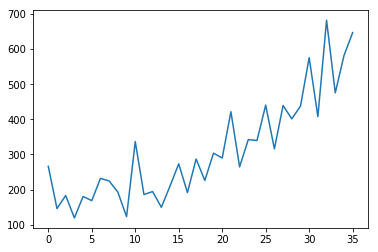

In [6]:
plt.plot(ts)

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean=pd.DataFrame.rolling(timeseries,window=6).mean()   #6 months rolling statistics
    rolstd=pd.DataFrame.rolling(timeseries,window=6).std()
    
    #Plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller Test
    print ('Results of Dickey-Fuller Test :')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags used','#Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print (dfoutput)

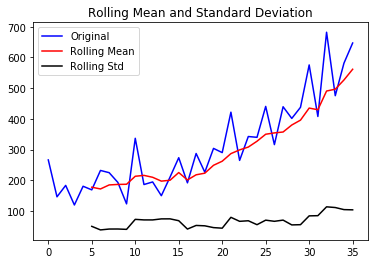

Results of Dickey-Fuller Test :
Test Statistic           3.060142
p-value                  1.000000
#Lags used              10.000000
#Observations used      25.000000
Critical value (1%)     -3.723863
Critical value (5%)     -2.986489
Critical value (10%)    -2.632800
dtype: float64


In [8]:
test_stationarity(ts)

**Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.
Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.**



#  How to make a time series stationary?

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

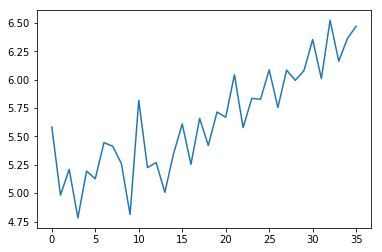

In [9]:
# Estimating and eliminating trend

ts_log=np.log(ts) 
plt.plot(ts_log)

For better understanding of trend, we do smoothing of time series.

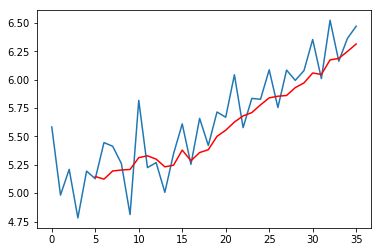

In [10]:
#Moving Average
moving_avg=pd.DataFrame.rolling(ts_log,6).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color='red')

In [11]:
ts_log_movingavg_diff=ts_log-moving_avg
ts_log_movingavg_diff

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5    -0.019672
6     0.322204
7     0.218379
8     0.057553
9    -0.397684
10    0.505547
11   -0.104221
12   -0.030615
13   -0.224959
14    0.101007
15    0.230793
16   -0.031372
17    0.301365
18    0.037230
19    0.214336
20    0.114503
21    0.416776
22   -0.103353
23    0.125126
24    0.049580
25    0.247205
26   -0.099367
27    0.223535
28    0.063584
29    0.108863
30    0.295391
31   -0.036662
32    0.349814
33   -0.024397
34    0.115164
35    0.156865
Name: Sales, dtype: float64

Lets drop these NaN values and check the plots to test stationarity.

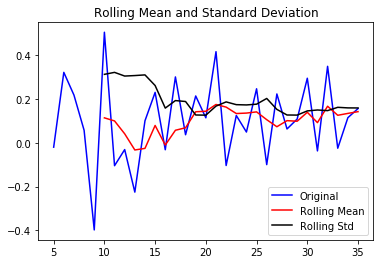

Results of Dickey-Fuller Test :
Test Statistic         -8.533922e+00
p-value                 1.020060e-13
#Lags used              0.000000e+00
#Observations used      3.000000e+01
Critical value (1%)    -3.669920e+00
Critical value (5%)    -2.964071e+00
Critical value (10%)   -2.621171e+00
dtype: float64


In [12]:
ts_log_movingavg_diff.dropna(inplace=True)
test_stationarity(ts_log_movingavg_diff)

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log_df=pd.DataFrame(ts_log_movingavg_diff)
ts_log_df.dropna(inplace=True)

In [36]:
decomposition_n=seasonal_decompose(ts_log_df,freq=12)

In [37]:
trend_n=decomposition_n.trend
seasonal_n=decomposition_n.seasonal
residual_n=decomposition_n.resid

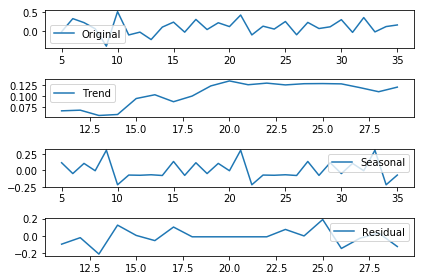

In [38]:
plt.subplot(411)
plt.plot(ts_log_df,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_n,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_n,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_n,label='Residual')
plt.legend(loc='best')
plt.tight_layout()


# Forecasting a Time Series

The ACF and PACF plots for the time series after differencing can be plotted as:

In [14]:
from statsmodels.tsa.stattools import acf,pacf

In [15]:
lag_acf=acf(ts_log_movingavg_diff,nlags=20)
lag_pacf=pacf(ts_log_movingavg_diff,nlags=20,method='ols')

In [17]:
type(ts_log_movingavg_diff)

pandas.core.series.Series

Text(0.5,1,'Autocorrelation Function')

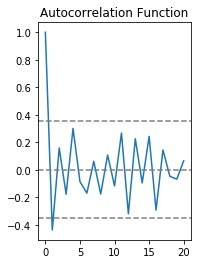

In [18]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_movingavg_diff)),linestyle='--',color='gray')  #Plotting the confidence intervals
plt.axhline(y=1.96/np.sqrt(len(ts_log_movingavg_diff)),linestyle='--',color='gray')   #z*sigma/sqrt(n)
plt.title('Autocorrelation Function')

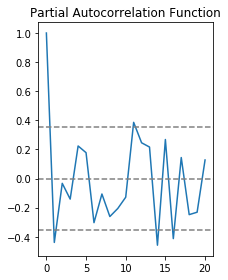

In [19]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_movingavg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_movingavg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [20]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.8959')

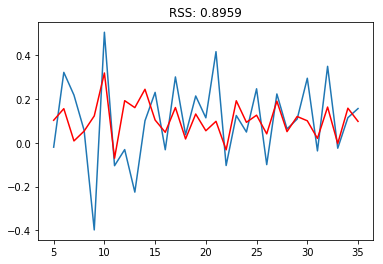

In [21]:
#AR MODEL
model = ARIMA(ts_log_movingavg_diff, order=(1,0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_movingavg_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_movingavg_diff)**2))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.9127')

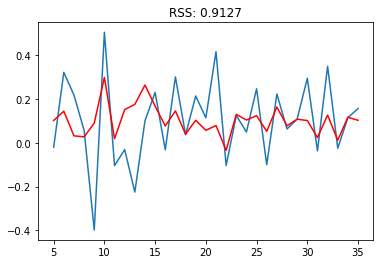

In [22]:
#MA MODEL
model = ARIMA(ts_log_movingavg_diff, order=(0,0,1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_movingavg_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_movingavg_diff)**2))

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 0.8940')

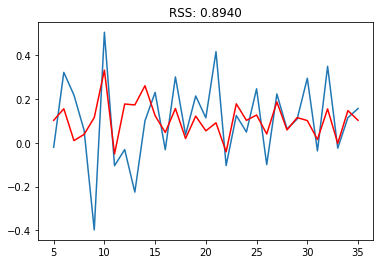

In [23]:
#ARIMA
model = ARIMA(ts_log_movingavg_diff, order=(1,0,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_movingavg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_movingavg_diff)**2))


In [45]:
results_ARIMA.predict(start= 1, end= 30)

6     0.155919
7     0.010388
8     0.038833
9     0.115547
10    0.332212
11   -0.050370
12    0.177608
13    0.173399
14    0.261156
15    0.124313
16    0.047800
17    0.157098
18    0.019941
19    0.122358
20    0.055026
21    0.091750
22   -0.040873
23    0.178430
24    0.102747
25    0.127365
26    0.040735
27    0.187084
28    0.059147
29    0.115412
30    0.102055
31    0.015597
32    0.155372
33   -0.002292
34    0.147506
35    0.103308
dtype: float64

In [49]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

In [25]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

5    0.103096
6    0.259015
7    0.269404
8    0.308237
9    0.423784
dtype: float64


In [28]:
predictions_ARIMA_log = pd.Series(ts_log_movingavg_diff.iloc[0], index=ts_log_movingavg_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

5    0.083424
6    0.239343
7    0.249731
8    0.288564
9    0.404111
dtype: float64

In [30]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Plotting the forecasting with the original time series data

Text(0.5,1,'RMSE: 0.1698')

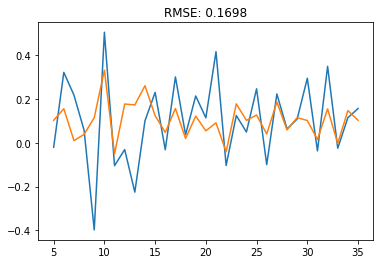

In [48]:
plt.plot(ts_log_movingavg_diff)
plt.plot(predictions_ARIMA_diff)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_diff-ts_log_movingavg_diff)**2)/len(ts_log_movingavg_diff)))